In [23]:
# import packages

import numpy as np
import pandas as pd
from math import log2

import plotly.plotly as py
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix
from skbio.stats.distance import mantel


# Data and Hierarchical Clustering

### HC with spliceosome dataset

In [3]:
## Define data process funcitons:

#standardize
def Std(dataframe):
    values = np.array(dataframe.values)
    values_norm = [(x-np.mean(x))/(np.std(x)+0.0001) for x in values]
    dataframe_std = pd.DataFrame(values_norm, columns = dataframe.columns, index = dataframe.index)
    return(dataframe_std)

##Read data and deal with data
#get T-cell dataframe
data_T_cell = data = pd.read_csv('All_gene_new.csv')
data_T_cell = data_T_cell.set_index('tracking_id')
data_T_cell.head()
#get gene list
Gene_List = data_T_cell.index.values.tolist()

data_T_cell.head(2)

,L027,L072,L078,L140,L102,L115,L133,L137,L149,L074,N048,N068,N090,N098,L005,L101,L062,L031
tracking_id,,,,,,,,,,,,,,,,,,
A1BG,4.435260,5.657840,3.185390,5.61407,6.765170,13.623500,1.577440,5.999400,1.645410,2.911800,5.905030,4.80408,4.220070,4.861380,6.083660,5.253290,2.621310,5.155390
A1BG-AS1,0.488185,0.503268,0.382777,1.58335,0.586863,0.494335,0.218729,0.577714,0.609716,0.376244,0.352573,0.72128,0.677991,0.522991,0.419846,0.435078,0.811181,0.480418


In [5]:
# get spliceosome list
splicesome = pd.read_csv("spliceosome.csv")
splicesome_list = set(splicesome['Approved Symbol'].values.tolist())
splicesome_list = list(splicesome_list)
splicesome_list = [sp.replace('ESS2', 'DGCR14') for sp in splicesome_list]

data_T_cell_sp = data_T_cell.loc[splicesome_list]
data_T_cell_sp_std = Std(data_T_cell_sp)
print('Stnadardized spliceosome gene expression data shape:',data_T_cell_sp_std.shape)

Stnadardized spliceosome gene expression data shape: (145, 18)


In [7]:
# reorder dataset to 4 control, 4 inactive, 10 active

sample_label = ['N068', 'N048', 'N090', 'N098', 'L005', 'L101', 'L062', 'L031', 'L027', 'L072', 'L078', 'L140', 'L102', 'L115', 'L133', 'L137', 'L149', 'L074']
data_T_cell_sp_std_reorder = data_T_cell_sp_std[sample_label]


{'Active': 'r', 'Inacive': 'b', 'Control': 'g'}


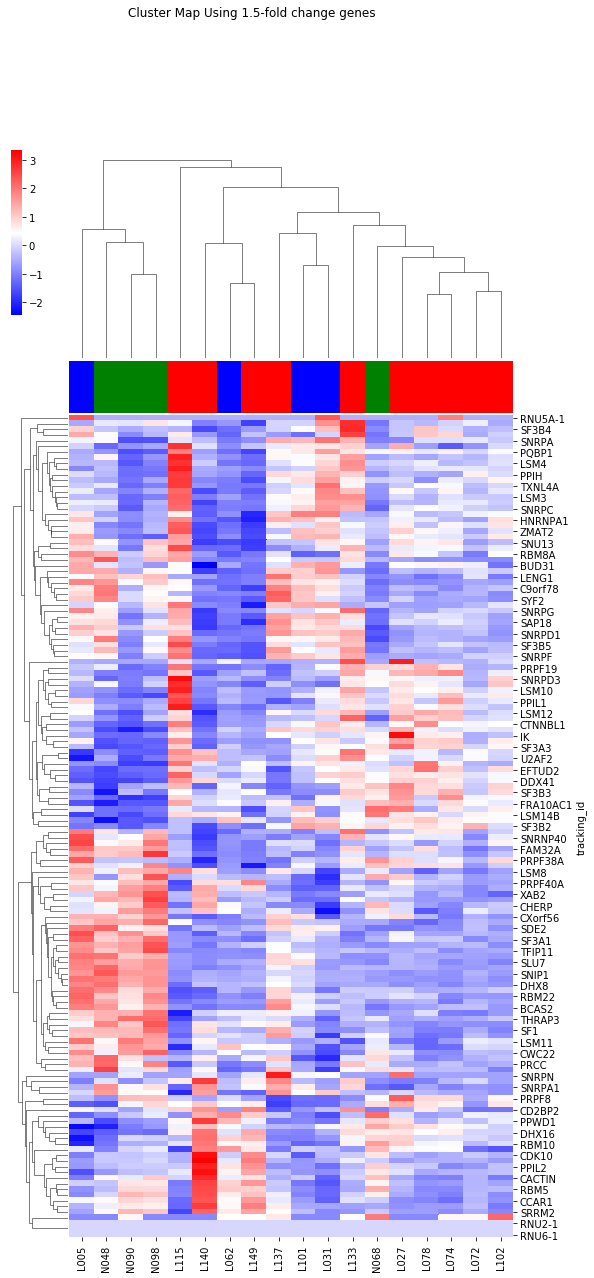

In [8]:
# produce the hierarchical clustering map

import seaborn as sns
import sys

groups = []
groups.extend(['Control']*4)
groups.extend(['Inacive']*4)
groups.extend(['Active']*10)
lut = dict(zip(set(groups), "rbg"))
print (lut)

col_colors = [lut[x] for x in groups] #groups.map(lut)
g = sns.clustermap(data_T_cell_sp_std_reorder, col_colors=col_colors, cmap = 'bwr', 
                   figsize=(9, 20)).fig.suptitle("Cluster Map Using 1.5-fold change genes ")

#save the fig
#plt.savefig("T_cell_fold1.5_std_cluster.png", bbox_inches='tight', dpi=400)

# Mantel Test

# IRI STD HC VS IRI PC1 Top 100 HC

In [18]:
# read dataset
IRI_Std_PCA_Abs00133 = pd.read_csv('IRI_Std_PCA_Abs00133.csv')
IRI_Std_PCA_Abs00133_T = IRI_Std_PCA_Abs00133.T

Data_IRI = pd.read_csv('Data_IRI.csv')
Data_IRI_T = Data_IRI.T

In [19]:
# deal with Datafram used to calculate distance matrix
new_header = IRI_Std_PCA_Abs00133_T.iloc[0] #grab the first row for the header
IRI_Std_PCA_Abs00133_T = IRI_Std_PCA_Abs00133_T[1:] #take the data less the header row
IRI_Std_PCA_Abs00133_T.columns = new_header
IRI_Std_PCA_Abs00133_T = IRI_Std_PCA_Abs00133_T.drop('Eigenvector_value')

new_header = Data_IRI_T.iloc[0] #grab the first row for the header
Data_IRI_T = Data_IRI_T[1:] #take the data less the header row
Data_IRI_T.columns = new_header

Data_IRI_T.head(2)

Unnamed: 0,AKR1B1,DDX31,HNRNPUL1,NUP188,GANAB,RCBTB2,TRAK1,C9orf114,CLDND1,RIOK3,...,CENPC,A1BG,ZNF271,SERINC3,ZNF792,NOL8,DNAJC3,PEX6,HNRNPD,CARD16
L140,0.0178707,0.00737709,0.00978578,0.0173507,0.0229099,0.0230641,0.00246477,0.167815,0.460945,0.027748,...,0.0223,0.15124,0.0286589,0.0294512,0.0327511,0.0541205,0.0032893,0.0580619,0.0632795,0.0011093
L149,0.011752,0.0095192,0.00612603,0.0172242,0.01198,0.0223744,0.00169604,0.157498,0.398864,0.0218264,...,0.0169514,0.222164,0.0238128,0.020852,0.0178764,0.0357049,0.00210785,0.0480664,0.039978,0.00158479


In [22]:
# calculate distance matrix
IRI_Std_PCA_Abs00133_DM = pd.DataFrame(distance_matrix(IRI_Std_PCA_Abs00133_T.values, IRI_Std_PCA_Abs00133_T.values), 
                                     index=IRI_Std_PCA_Abs00133_T.index, 
                                     columns=IRI_Std_PCA_Abs00133_T.index)
print(IRI_Std_PCA_Abs00133_DM.shape)

Data_IRI_DM = pd.DataFrame(distance_matrix(Data_IRI_T.values, Data_IRI_T.values), 
                                     index=Data_IRI_T.index, 
                                     columns=Data_IRI_T.index)
print(Data_IRI_DM.shape)


(17, 17)
(17, 17)


In [24]:
# apply mantel test
coeff, p_value, n = mantel(IRI_Std_PCA_Abs00133_DM, Data_IRI_DM,
                           permutations=3000, alternative='two-sided', method = 'pearson')
print('coffeience = ',round(coeff, 4))
print('P-value = ',round(p_value,4))
print('Thus, we see a strong positive correlation between the two matrices.')

coffeience =  0.9832
P-value =  0.0003
Thus, we see a strong positive correlation between the two matrices.
